In [9]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy.linalg import expm

def plot_quantum_evolution(N, M, n_excited_states, times, adiabatic_energies, true_energies, adiabatic_diff, energy_gaps, overlaps_all_states, t_total, dt):
    """
    Plot the quantum system evolution with energies, energy gaps, and wavefunction overlaps.
    
    Parameters:
    - N, M: System parameters
    - n_excited_states: Number of excited states to track
    - times: Array of time points for evolution
    - adiabatic_energies: Adiabatic energies during evolution
    - true_energies: Array of true energies (from exact diagonalization)
    - adiabatic_diff: Difference between adiabatic and ground state energies
    - energy_gaps: Gaps between ground and excited states
    - overlaps_all_states: Overlap between wavefunctions at each time and each state
    - t_total: Total evolution time
    - dt: Time step size
    """
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
    cmap = plt.get_cmap("gist_rainbow")
    colors = [cmap(i / (n_excited_states + 1)) for i in range(n_excited_states + 1)]
    
    # Add a super title for the whole figure
    fig.suptitle(f"N={N}, M={M}, T={t_total}, dt={np.round(dt, 3)}")
    
    # First plot: Energies vs Time
    ax = axes[0]
    ax.plot(times, adiabatic_energies, color="black", marker=".", linestyle="", label="$\Psi^\dagger(t) H \Psi(t)$")
    for i in range(n_excited_states):
        ax.plot(times, true_energies[:, i], color=colors[i], label=f"$E_{i}$")
    
    ax.set_title(f"Energies")
    ax.set_xlabel("Time [t]")
    ax.set_ylabel("Energy")
    ax.legend(loc="lower center", ncol=(n_excited_states+1)//2)
    ax.grid(True)
    
    # Second plot: Energy Gaps vs Time
    ax = axes[1]
    ax.plot(times, adiabatic_diff, ".", color="black", label="$\Psi^\dagger(t) H \Psi(t) - E_0$")
    for i in range(n_excited_states):
        ax.plot(times, energy_gaps[:, i], color=colors[i], label=f"$\Delta E = E_{i}-E_0$")
    
    ax.set_title(f"Energy Gaps")
    ax.set_xlabel("Time [t]")
    ax.set_ylabel("Energy Difference")
    ax.legend(loc="upper center", ncol=(n_excited_states+1)//2)
    ax.grid(True)
    ax.set_ylim(0, 3)
    
    # Third plot: Overlaps vs Time
    ax = axes[2]
    for i in range(n_excited_states):
        ax.plot(times, overlaps_all_states[:, i], color=colors[i], label=f"$\Psi(t)^\dagger \Psi_{i}$")
    
    ax.set_title(f"Overlaps")
    ax.set_xlabel("Time [t]")
    ax.set_ylabel("Wavefunction Overlap")
    ax.legend(loc="center left")
    ax.grid(True)
    ax.set_ylim(-0.1, 1.1)
    
    # Adjust layout for better spacing
    fig.tight_layout()
    
    # Show the figure
    plt.show()

def simulate_and_plot(N, M, mu, init_J, init_V, J, V, t_total=100, dt=1, n_excited_states = 3):

    initial_hamiltonian = construct_initial_hamiltonian(N, M, mu) + construct_hamiltonian(N, M, init_J, init_V)
    final_hamiltonian = construct_hamiltonian(N, M, J, V)
    times = np.linspace(0, t_total, int(t_total / dt))

    def interpolate_hamiltonian(H0, Hf, t, t_total):
        return (1 - t / t_total) * H0 + (t / t_total) * Hf

    def evolve_wavefunction(psi, H, dt, hbar=1.0):
        """Evolve the wavefunction by a small time step dt using the Hamiltonian H."""
        U = expm(-1j * H * dt)
        psi = np.dot(U, psi)
        return psi

    eigenvalues_0, eigenvectors_0 = exact_diagonalize(initial_hamiltonian)
    psi_0 = eigenvectors_0[0]  # Ground state of H0

    adiabatic_wavefunctions = [psi_0]
    true_energies = []
    adiabatic_energies = []
    overlaps_all_states = []

    psi = psi_0.copy()

    for t in times:
        # Interpolate Hamiltonian at time t
        instantaneous_hamiltonian = interpolate_hamiltonian(initial_hamiltonian, final_hamiltonian, t, t_total)

        # Exact diagonalization to get the true energies
        eigenvalues, eigenvectors = exact_diagonalize(instantaneous_hamiltonian)
        true_energies.append(eigenvalues)

        # Evolve the wavefunction
        psi = evolve_wavefunction(psi, instantaneous_hamiltonian, dt)

        # Normalize the wavefunction
        psi = psi / np.linalg.norm(psi)

        # Store the wavefunction at this time step
        adiabatic_wavefunctions.append(psi)

        # Calculate the adiabatic energy <psi|H|psi>
        adiabatic_energy = np.real(np.conj(psi).T @ instantaneous_hamiltonian @ psi)
        adiabatic_energies.append(adiabatic_energy)

        # Calculate overlaps |<eigenstate|psi>|^2 for all states
        overlaps = [np.abs(np.conj(eigenvectors[i]).T @ psi)**2 for i in range(n_excited_states)]
        overlaps_all_states.append(overlaps)

    # Convert lists to numpy arrays
    true_energies = np.array(true_energies)
    overlaps_all_states = np.array(overlaps_all_states)

    # Compute energy gaps and adiabatic differences
    energy_gaps = [eigenvalues - eigenvalues[0] for eigenvalues in true_energies]
    adiabatic_diff = np.array(adiabatic_energies) - true_energies[:, 0]

    # Call the plot function
    plot_quantum_evolution(N, M, n_excited_states, times, adiabatic_energies, true_energies, adiabatic_diff, np.array(energy_gaps), overlaps_all_states, t_total, dt)


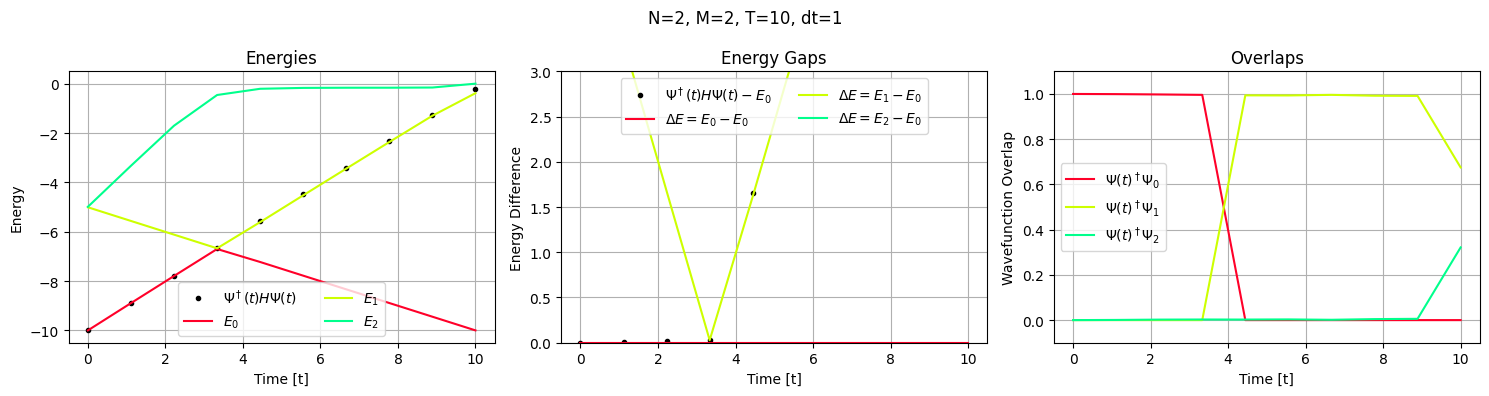

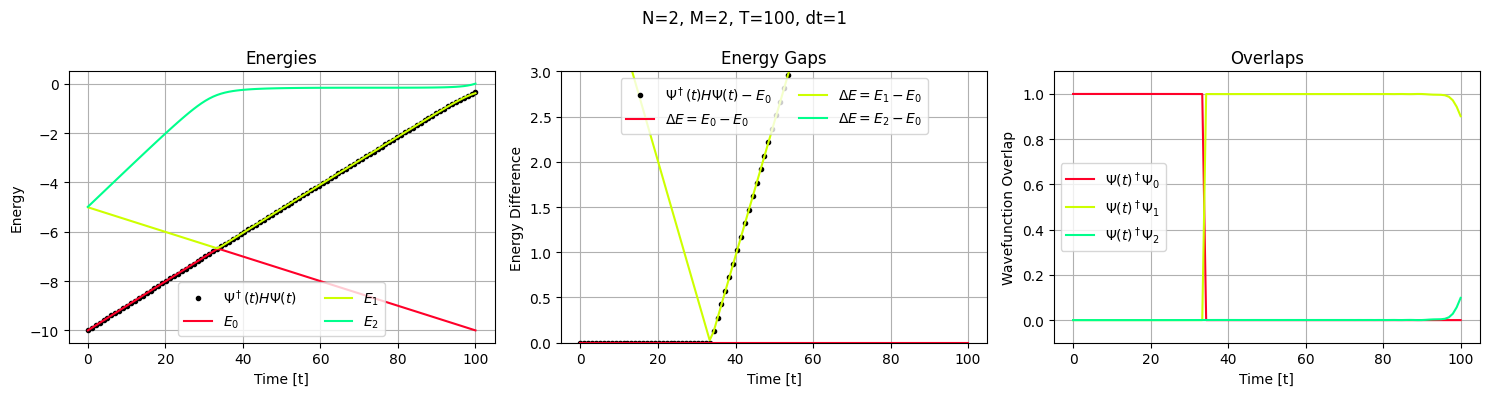

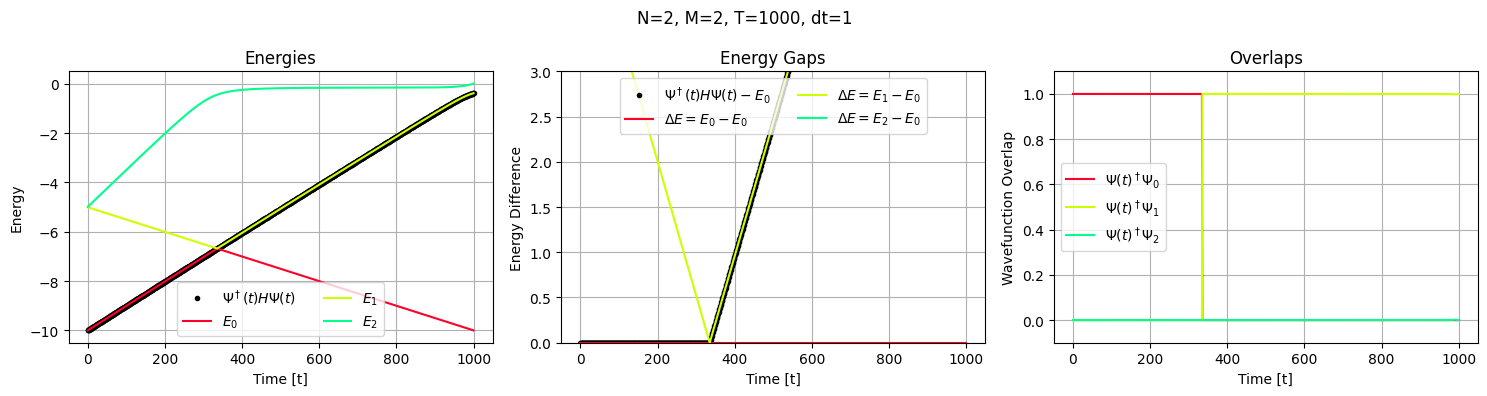

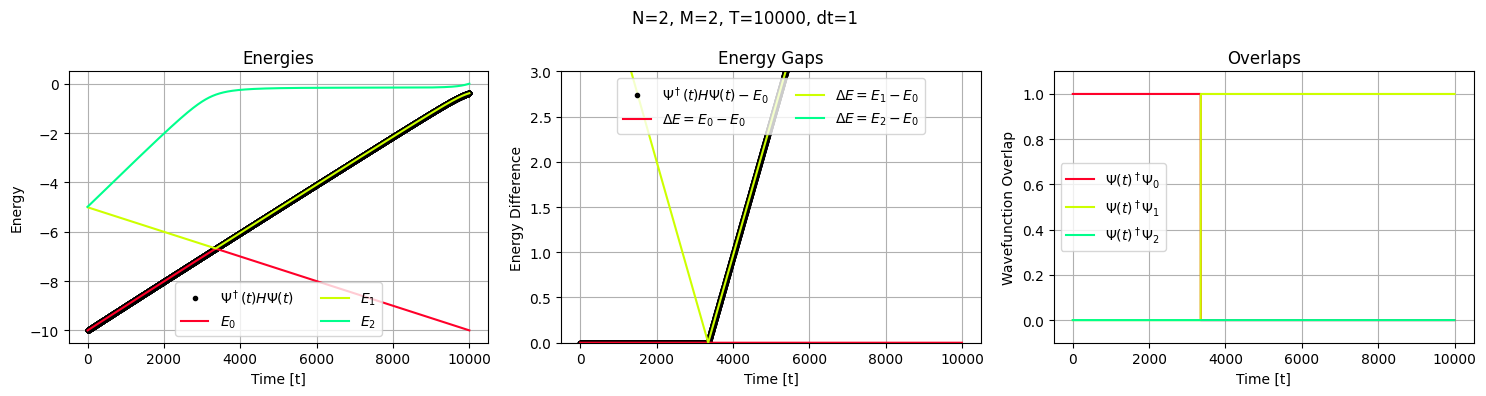

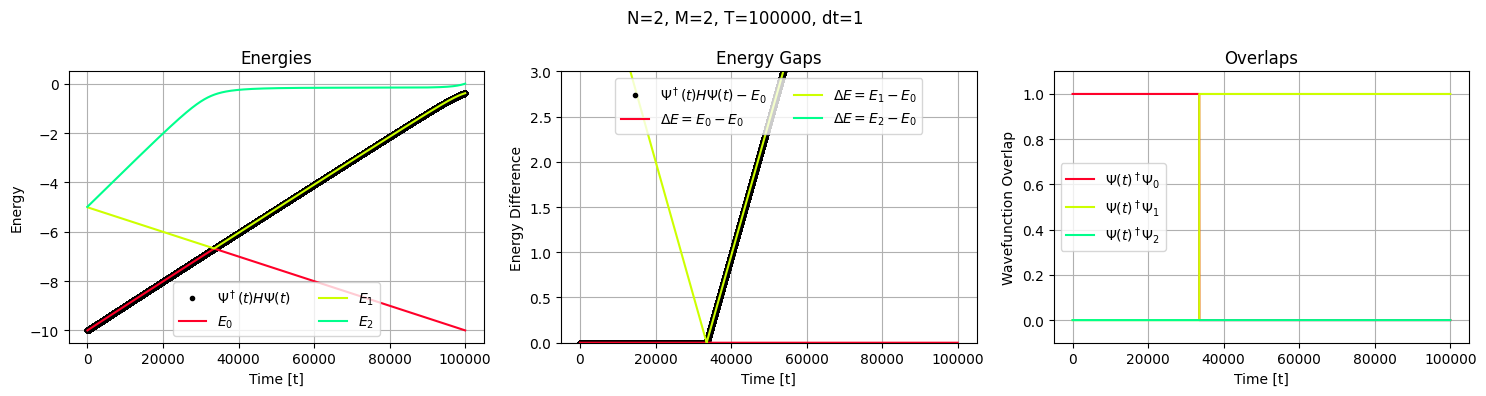

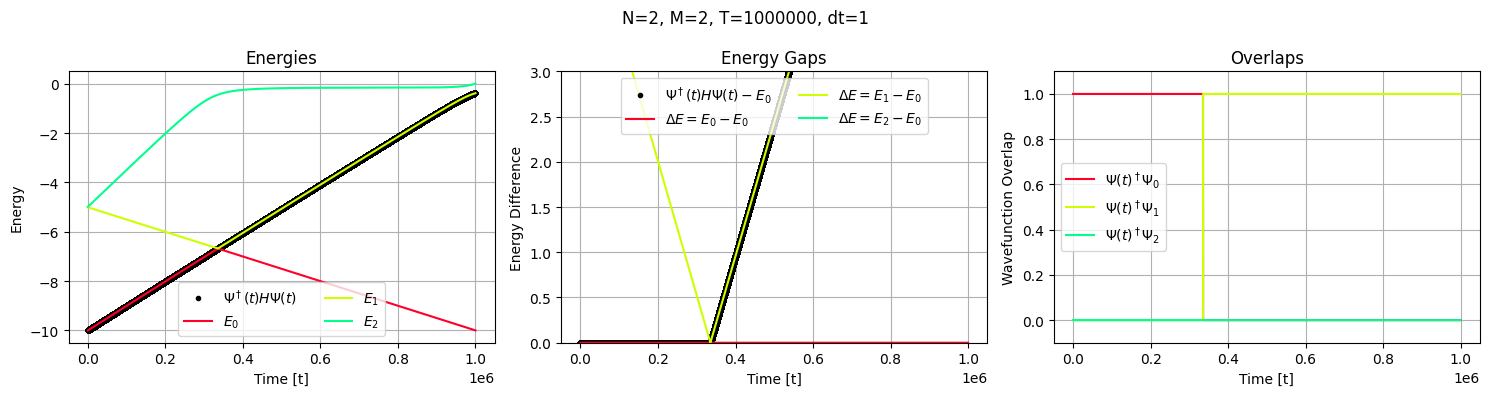

KeyboardInterrupt: 

In [12]:
N = 2
M = 2

mu = 5
init_J = 0.01
init_V = 0.01

J = 1
V = 10

total_times = [10, 10e1, 10e2, 10e3, 10e4, 10e5, 10e6]
total_times = [int(t) for t in total_times]
dt = 1

n_excited_states = 3

for t_total in total_times:
    
    simulate_and_plot(N,M,mu, init_J, init_V, J, V, t_total, dt, n_excited_states)